In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
%cd /content/drive/MyDrive/ScaniaAB-heavy_vehicles

/content/drive/MyDrive/ScaniaAB-heavy_vehicles


## Scania AB
-----------------------

**Business**: Scania AB is a major Swedish manufacturer focusing on automobiles. It also manufactures diesel engines for heavy vehicles as well as marine and general industrial applications. The company is planning to enter the American Market by setting up their manufacturing unit there. 

**Business Objective**: to identify the factors that influence the price of cars in America, based on which they can manipulate the design of their cars and can take good start in the business.

**Objective of Analysis**:
1. Variables that affect the price of cars in America
2. To what extent do these variables affect the price
3. Suggest possible requirements for Scania AB to work on

**Dependent Variable**: Price

**Steps**
1. Data Cleaning
2. EDA Analysis
3. Data Preparation
4. Splitting into train and test set
5. Feature Scaling
6. Model Building
    1. Model 1: Inclusive of car companies
    2. Model 2: Exclusive of car companies
7. Residual Analysis
8. Predicting the Model
9. Model Evaluation
10. Suggestions
11. Glossary of Terms

--------------

**The process of Model Building.**

1. 2 different approaches, with and without car companies are taken since in Model 1, the final features are dominated by car company names. While this gives clear indication that Car Company is important, Scania AB, initially, may not be able to have control over their Brand image in America. Therefore, we need to identify other possible features as well. 

2. Steps taken for analysis:
    1. RFE: to bring down the number of feature to a more reasonable quantity
    2. Manualing dropping features
        1. Deleting columns by looking for features with a high p-value (>0.05)
        2. Looking at the VIF (Variance Inflation Factor) to looking for highly correlated features (deleting ones with VIF>5)
3. Metrics to look at:
    1. R-Squared
    2. Adj. R-Squared
    3. F-statistic
    4. AIC

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Splitting dataset into train and test set
from sklearn.model_selection import train_test_split

#Feature Scaling
from sklearn.preprocessing import MinMaxScaler

#Building stats models and getting the features' VIF
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#RFE: need to use linear regression along with RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

#Metrics for the final model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [35]:
#Reading the dataset
cars = pd.read_csv('CarPrice_Assignment.csv',encoding='UTF-8', index_col=0)
cars.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,,,,,,,,,,,,,,,,,,,,,
1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


--------------------

<a id='data-cleaning'></a>

## Data Cleaning

This section involves checking for inconsistencies in values that could hinder the efficiency of the model.

**Steps taken:**
1. Handle Missing Values
2. Convert to relevant Data Types
2. Clean format for all columns
    1. Split CarName to get Company Name
    2. Delete CarName column (has too many unique values and less likely to contribute to the analysis)
3. Convert all values to Lower case since python is case-sensitive.

In [36]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 1 to 205
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

**Handle missing values**

It is evident from the basic info above that all the columns are non-null. Therefore, there is no need to handle any missing values in this case. 

------------------

**Convert to relevant data types**

Another thing to notice is that all the categorical variables are left have their data type as object, except for symboling. It is saved as int64. This should be converted to object type. Later it will be converted to a dummy variable, but to get better insights for EDA it would be a good idea to convert it to object at this point.

In [37]:
#Converting the symbol column to string
cars['symboling'] = cars['symboling'].astype(str)
cars['symboling'].dtype

dtype('O')

**Clean format for all columns**
1. CarName -> create new column with just the company name & making it lower case

In [38]:
#Splitting CarName to get the first word (characters before the first space)
cars['car_company'] = list(map(lambda x: str(x.split(' ',1)[0]),cars.CarName))
cars.car_company.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

The unique company values show that there are same companies with different spellings & typos. This needs to be changed to standardise it further and to get more reliable results. 
Names to work on:
1. maxda -> mazda
2. porcshce -> porsche
3. toyouta -> toyota
4. vokswagen, vw -> volkswagen

In [39]:
cars['car_company'] = cars['car_company'].replace({'maxda':'mazda',
                                                   'porcshce':'porsche',
                                                   'toyouta':'toyota',
                                                   'vokswagen':'volkswagen',
                                                   'vw': 'volkswagen'
                                                  } )
cars['car_company'].nunique()  #number of new unique car brands

23

In [40]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 1 to 205
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    object 
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

In [41]:
cars = cars.drop('CarName',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


**Lower Case all object values**

This is to mainly avoid any duplicates being present which may go unnoticed due to python's case sensitivity. This is evident with car companies where Nissan and nissan are considered as separate values

In [42]:
#cars_object selects all the column names with O as their data type
cars_object = cars.select_dtypes(include=['O']).columns
cars[cars_object] = cars[cars_object].apply(lambda x: x.str.lower())

-------------------------

<a id='eda-analysis'></a>

## EDA Analysis

It's time to analyse the cleaned dataset to see if we can identify any basic patterns between different variables

**Steps taken:**
1. Checking Correlation amongst the numberical variables
2. Analysing the categorical variables
3. Deriving variables

-----------

**Correlation amongst the numberical variables**

In [43]:
cars.describe()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


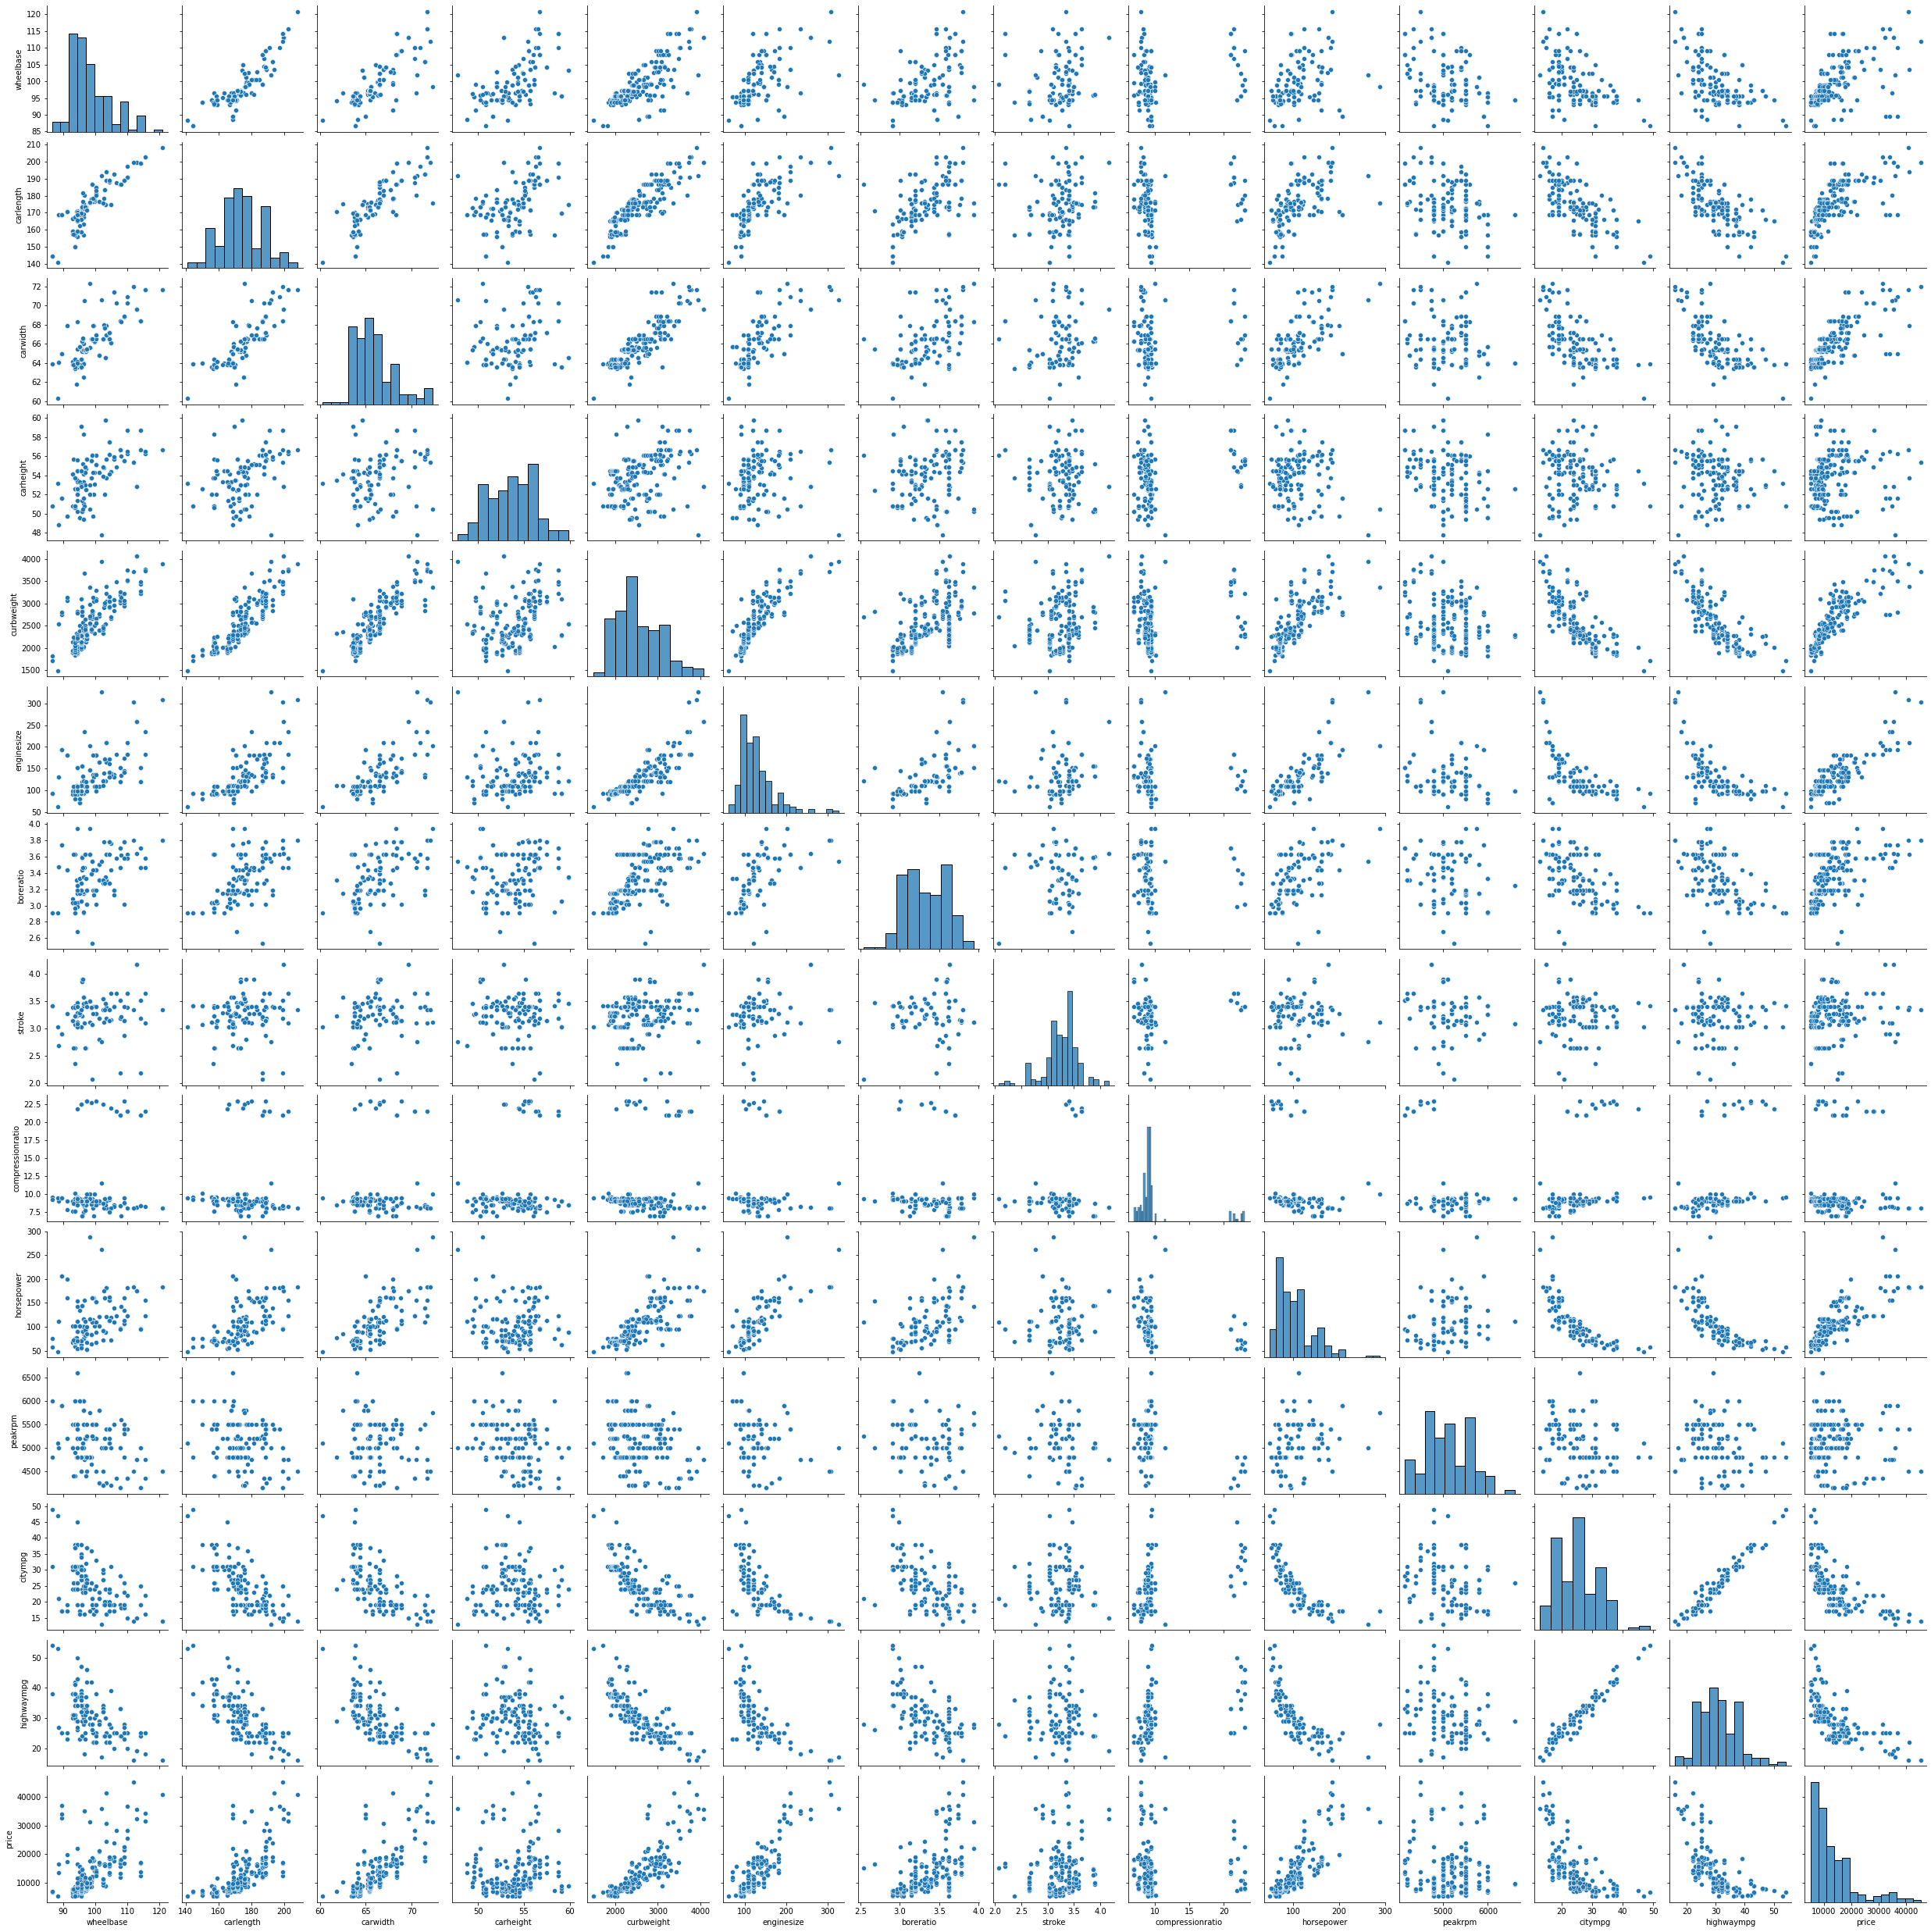

In [27]:
#Generating a pair plot
plot = cars.select_dtypes(['int64', 'float64'])
sns_plot = sns.pairplot(plot)
sns_plot.figure.savefig("output.png")

In [29]:
corr = cars.corr()
corr.style.background_gradient(cmap='Purples')


,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
wheelbase,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.488750,0.160959,0.249786,0.353294,-0.360469,-0.470414,-0.544082,0.577816
carlength,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.606454,0.129533,0.158414,0.552623,-0.287242,-0.670909,-0.704662,0.682920
carwidth,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559150,0.182942,0.181129,0.640732,-0.220012,-0.642704,-0.677218,0.759325
carheight,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.171071,-0.055307,0.261214,-0.108802,-0.320411,-0.048640,-0.107358,0.119336
curbweight,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.648480,0.168790,0.151362,0.750739,-0.266243,-0.757414,-0.797465,0.835305
enginesize,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.583774,0.203129,0.028971,0.809769,-0.244660,-0.653658,-0.677470,0.874145
boreratio,0.488750,0.606454,0.559150,0.171071,0.648480,0.583774,1.000000,-0.055909,0.005197,0.573677,-0.254976,-0.584532,-0.587012,0.553173
stroke,0.160959,0.129533,0.182942,-0.055307,0.168790,0.203129,-0.055909,1.000000,0.186110,0.080940,-0.067964,-0.042145,-0.043931,0.079443
compressionratio,0.249786,0.158414,0.181129,0.261214,0.151362,0.028971,0.005197,0.186110,1.000000,-0.204326,-0.435741,0.324701,0.265201,0.067984
horsepower,0.353294,0.552623,0.640732,-0.108802,0.750739,0.809769,0.573677,0.080940,-0.204326,1.000000,0.131073,-0.801456,-0.770544,0.808139


### Basic Analysis

From the correlation matrix and the scatter plots we can see that the following variables have a moderate/high correlation with the price:
1. Car length
2. Car width
3. Curbweight
4. Enginesize
5. Horsepower
6. Mileage(highway and city) to some extent

While these have high correlation with the price, it appears that some have a good correlation with each other as well. This suggests possible multicollinearity.

Also, compression ratio seems to have values within a specific range of a value near 10 and 20. Could be more of a cateogrical variable

------------------

**Analysing Categorical Variables**

In [44]:
cars.describe(include=['object'])

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,car_company
count,205,205,205,205,205,205,205,205,205,205,205
unique,6,2,2,2,5,3,2,7,7,8,22
top,0,gas,std,four,sedan,fwd,front,ohc,four,mpfi,toyota
freq,67,185,168,115,96,120,202,148,159,94,32


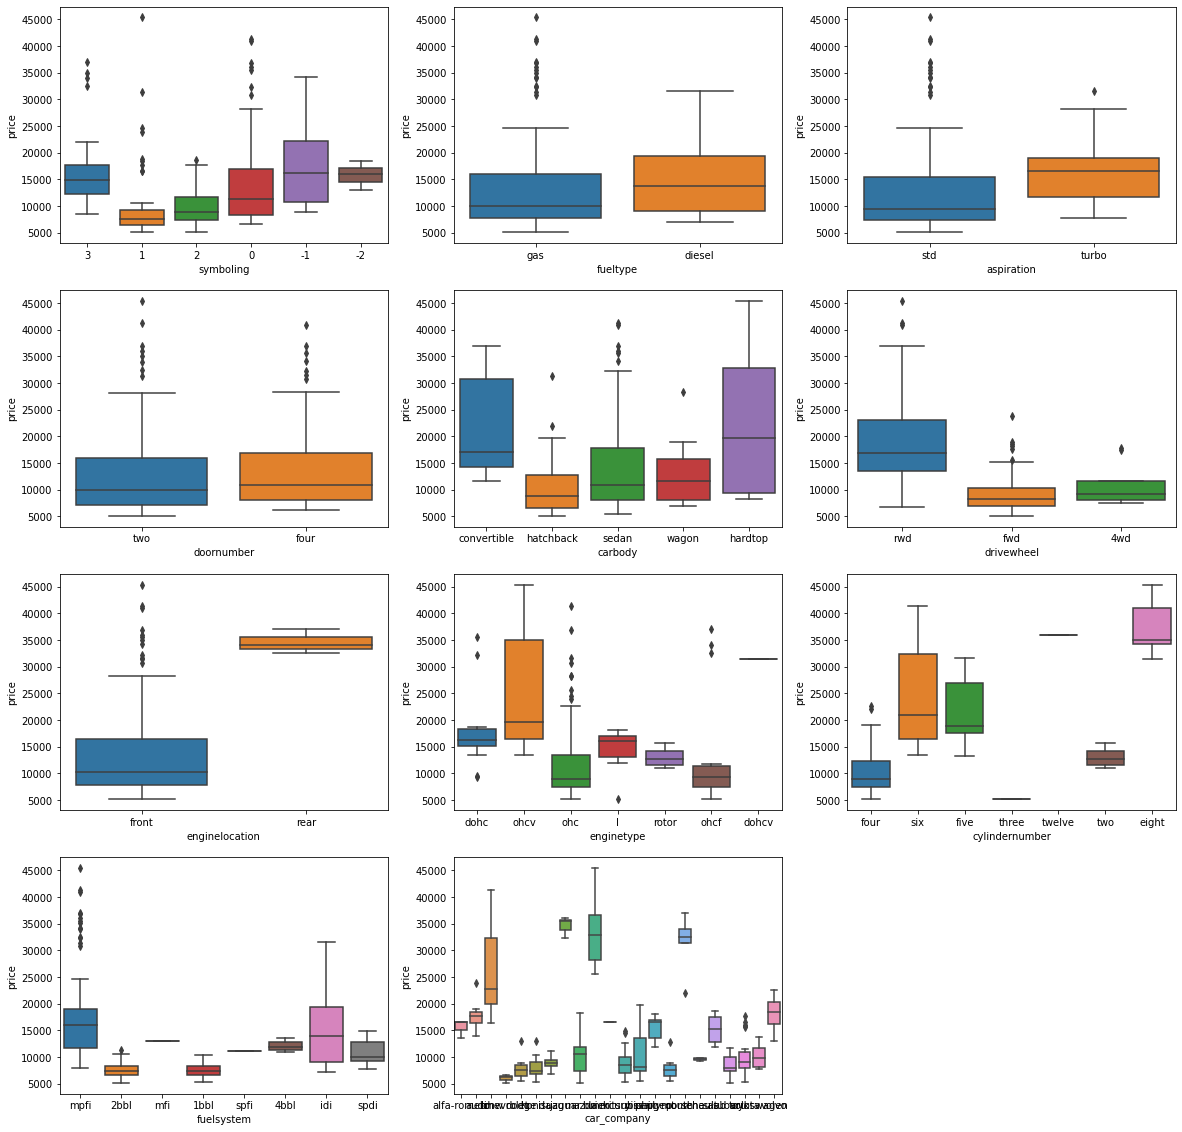

<Figure size 432x288 with 0 Axes>

In [45]:
plt.figure(figsize=(20, 20))
plt.subplot(4,3,1)
sns.boxplot(x = 'symboling', y = 'price', data = cars)
plt.subplot(4,3,2)
sns.boxplot(x = 'fueltype', y = 'price', data = cars)
plt.subplot(4,3,3)
sns.boxplot(x = 'aspiration', y = 'price', data = cars)
plt.subplot(4,3,4)
sns.boxplot(x = 'doornumber', y = 'price', data = cars)
plt.subplot(4,3,5)
sns.boxplot(x = 'carbody', y = 'price', data = cars)
plt.subplot(4,3,6)
sns.boxplot(x = 'drivewheel', y = 'price', data = cars)
plt.subplot(4,3,7)
sns.boxplot(x = 'enginelocation', y = 'price', data = cars)
plt.subplot(4,3,8)
sns.boxplot(x = 'enginetype', y = 'price', data = cars)
plt.subplot(4,3,9)
sns.boxplot(x = 'cylindernumber', y = 'price', data = cars)
plt.subplot(4,3,10)
sns.boxplot(x = 'fuelsystem', y = 'price', data = cars)
plt.subplot(4,3,11)
sns.boxplot(x = 'car_company', y = 'price', data = cars)
plt.show()
plt.savefig('foo.png')

**Deleting Irrelevant Columns**

The column descriptions and the graphs show that fueltype and enginelocation have unique values with frequency higher than 90%.
* Gas in fuel type has 185
* Front in engine location has 203

This means that the data is skewed in these columns and are less likely to affect future analysis, therefore should be deleted

In [46]:
cars = cars.drop(['fueltype','enginelocation'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


### Basic Analysis

To possibly identify the relation between different categorical variables, the box plots and their alignments can be looked it. 

1. Fuel Type & Aspiration: while the median lines are at different spots, it seems that the boxes are overlapping quite a lot. This indicates their poor correlation with price. This is supported by their description as well which indicated heavy bias.
2. Door number & Symboling: the boxes and the median lines overlap and match thus indicating low to almost no correlation
3. Car body: It seems that hatchback and convertible have some difference while sedan,wagon and hatchback have median around the same range
4. Drive wheel: this is rwd, fwd and 4wd which have median around the same range however rwd shows a difference. It indicates that rwd wheel may be a reason for high prices.
5. Engine Location: looking just at the bar plot we can say that this is a variable to count on however considering the description it shows that this is a biased variable with front have 202 entries while rear has 3. This bias makes it an unnecassary column.
6. Engine type & Cylinder Number: these 2 variables 
7. Fuel System: Some values in this may be an indicator while others have overlapping boxes
8. Fuel System: Majority of the box plots fall under the same range however it is seen that mpfi has more outliers in the higher range. This may suggest that mpfi may be a factor affecting the price
9. Car Company: there's not much to say about this on the basis of the plot, however It appears that there are 4 car companies that indicate a much higher price as compared to others.

---------------------
<a id='data-preparation'></a>


## Data Preparation

**Premise**: the point of this section is to convert all object values to numerical. This is necessary before moving on to modelling since statsmodel and sklearn only accept numerical values. 

2 possible ways of dealing with the categorical variables is to:

1. Aspiration & Door Number: convert to 0 & 1 values in a single column (no need for dummy variables)
2. Rest of the categorical variables: these could be converted to dummy variables since they don't have that many levels plus they are not ordinal values.

------------------- 

**Converting values to 1s & 0s**

In [47]:
replace_map = {'std':0,'turbo':1,
               'two':0,'four':1,
              }

In [48]:
cars_encoded = cars.copy()
cars_encoded['aspiration'].replace(replace_map, inplace=True)
cars_encoded['doornumber'].replace(replace_map, inplace=True)

cars_encoded[['aspiration','doornumber']].head()

,aspiration,doornumber
car_ID,,
1,0,0
2,0,0
3,0,0
4,0,1
5,0,1


2. Converting to Dummy Variables:
    * Symboling
    * Car Body
    * Drive Wheel
    * Engine Type
    * Fuel System
    * Cylinder Number
    * Car Company

In [49]:
#Converting all the categorical variables to dummy
symbol = pd.get_dummies(cars_encoded['symboling'],prefix='symbol_', drop_first = True)
cars_encoded = pd.concat([cars_encoded,symbol], axis = 1)

carbody = pd.get_dummies(cars_encoded['carbody'],prefix='body_', drop_first = True)
cars_encoded = pd.concat([cars_encoded,carbody], axis = 1)

wheel = pd.get_dummies(cars_encoded['drivewheel'], prefix='wheel_', drop_first = True)
cars_encoded = pd.concat([cars_encoded,wheel], axis = 1)

engine = pd.get_dummies(cars_encoded['enginetype'], prefix='engine_', drop_first = True)
cars_encoded = pd.concat([cars_encoded,engine], axis = 1)

fuel = pd.get_dummies(cars_encoded['fuelsystem'], prefix='fuel_', drop_first = True)
cars_encoded = pd.concat([cars_encoded,fuel], axis = 1)

fuel = pd.get_dummies(cars_encoded['cylindernumber'], prefix='cylinder_', drop_first = True)
cars_encoded = pd.concat([cars_encoded,fuel], axis = 1)

fuel = pd.get_dummies(cars_encoded['car_company'], prefix='car_', drop_first = True)
cars_encoded = pd.concat([cars_encoded,fuel], axis = 1)

In [50]:
cars_encoded.drop(['symboling','carbody','drivewheel','enginetype','fuelsystem','car_company','cylindernumber'], axis = 1, inplace = True)
cars_encoded.head()

,aspiration,doornumber,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,...,car__nissan,car__peugeot,car__plymouth,car__porsche,car__renault,car__saab,car__subaru,car__toyota,car__volkswagen,car__volvo
car_ID,,,,,,,,,,,,,,,,,,,,,
1,0,0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,0,0,0,0,0,0,0,0,0
2,0,0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,0,0,0,0,0,0,0,0,0
3,0,0,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,...,0,0,0,0,0,0,0,0,0,0
4,0,1,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,...,0,0,0,0,0,0,0,0,0,0
5,0,1,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,...,0,0,0,0,0,0,0,0,0,0


-------------------

<a id='split'></a>

## Splitting Dataset into Train and Test Set

Now we are ready to start building a model, our dataset is all ready! 

Before moving to that step we divide the dataset into training and test dataset. Considering the fact that there are only 205 entires, they could be divided in the ratio of 90:10

In [51]:
np.random.seed(0)
cars_train, cars_test = train_test_split(cars_encoded, train_size = 0.9, test_size = 0.1, random_state = 100)

In [52]:
cars_train.shape

(184, 67)

---------------------

<a id='feature-scaling'></a>

## Feature Scaling

This step is to basically normalise all the numerical variables, which helps speed up the process of calculation in modelling.

In [53]:
scaler = MinMaxScaler()
num_vars = ['wheelbase','carlength','carwidth','carheight','curbweight','enginesize','boreratio','stroke','compressionratio','horsepower','peakrpm','citympg','highwaympg','price']
cars_train[num_vars] = scaler.fit_transform(cars_train[num_vars])
cars_train.describe()

,aspiration,doornumber,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,...,car__nissan,car__peugeot,car__plymouth,car__porsche,car__renault,car__saab,car__subaru,car__toyota,car__volkswagen,car__volvo
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,...,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,0.179348,0.559783,0.415217,0.530567,0.462591,0.487953,0.408966,0.245898,0.552290,0.568038,...,0.092391,0.054348,0.038043,0.027174,0.010870,0.021739,0.059783,0.152174,0.059783,0.043478
std,0.384690,0.497768,0.202542,0.198877,0.180524,0.205413,0.203720,0.155594,0.191704,0.147907,...,0.290368,0.227321,0.191823,0.163034,0.103972,0.146228,0.237731,0.360169,0.237731,0.204488
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.272414,0.409756,0.308333,0.341667,0.251746,0.135849,0.412500,0.495238,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.350000,0.515447,0.425000,0.516667,0.356672,0.184906,0.550000,0.580952,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.510345,0.657724,0.518750,0.641667,0.553724,0.317925,0.742857,0.638095,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Creating Heatmap to look for correlations

Before jumping to correlations, we can just get a basic overview of all the correlations at this point now.

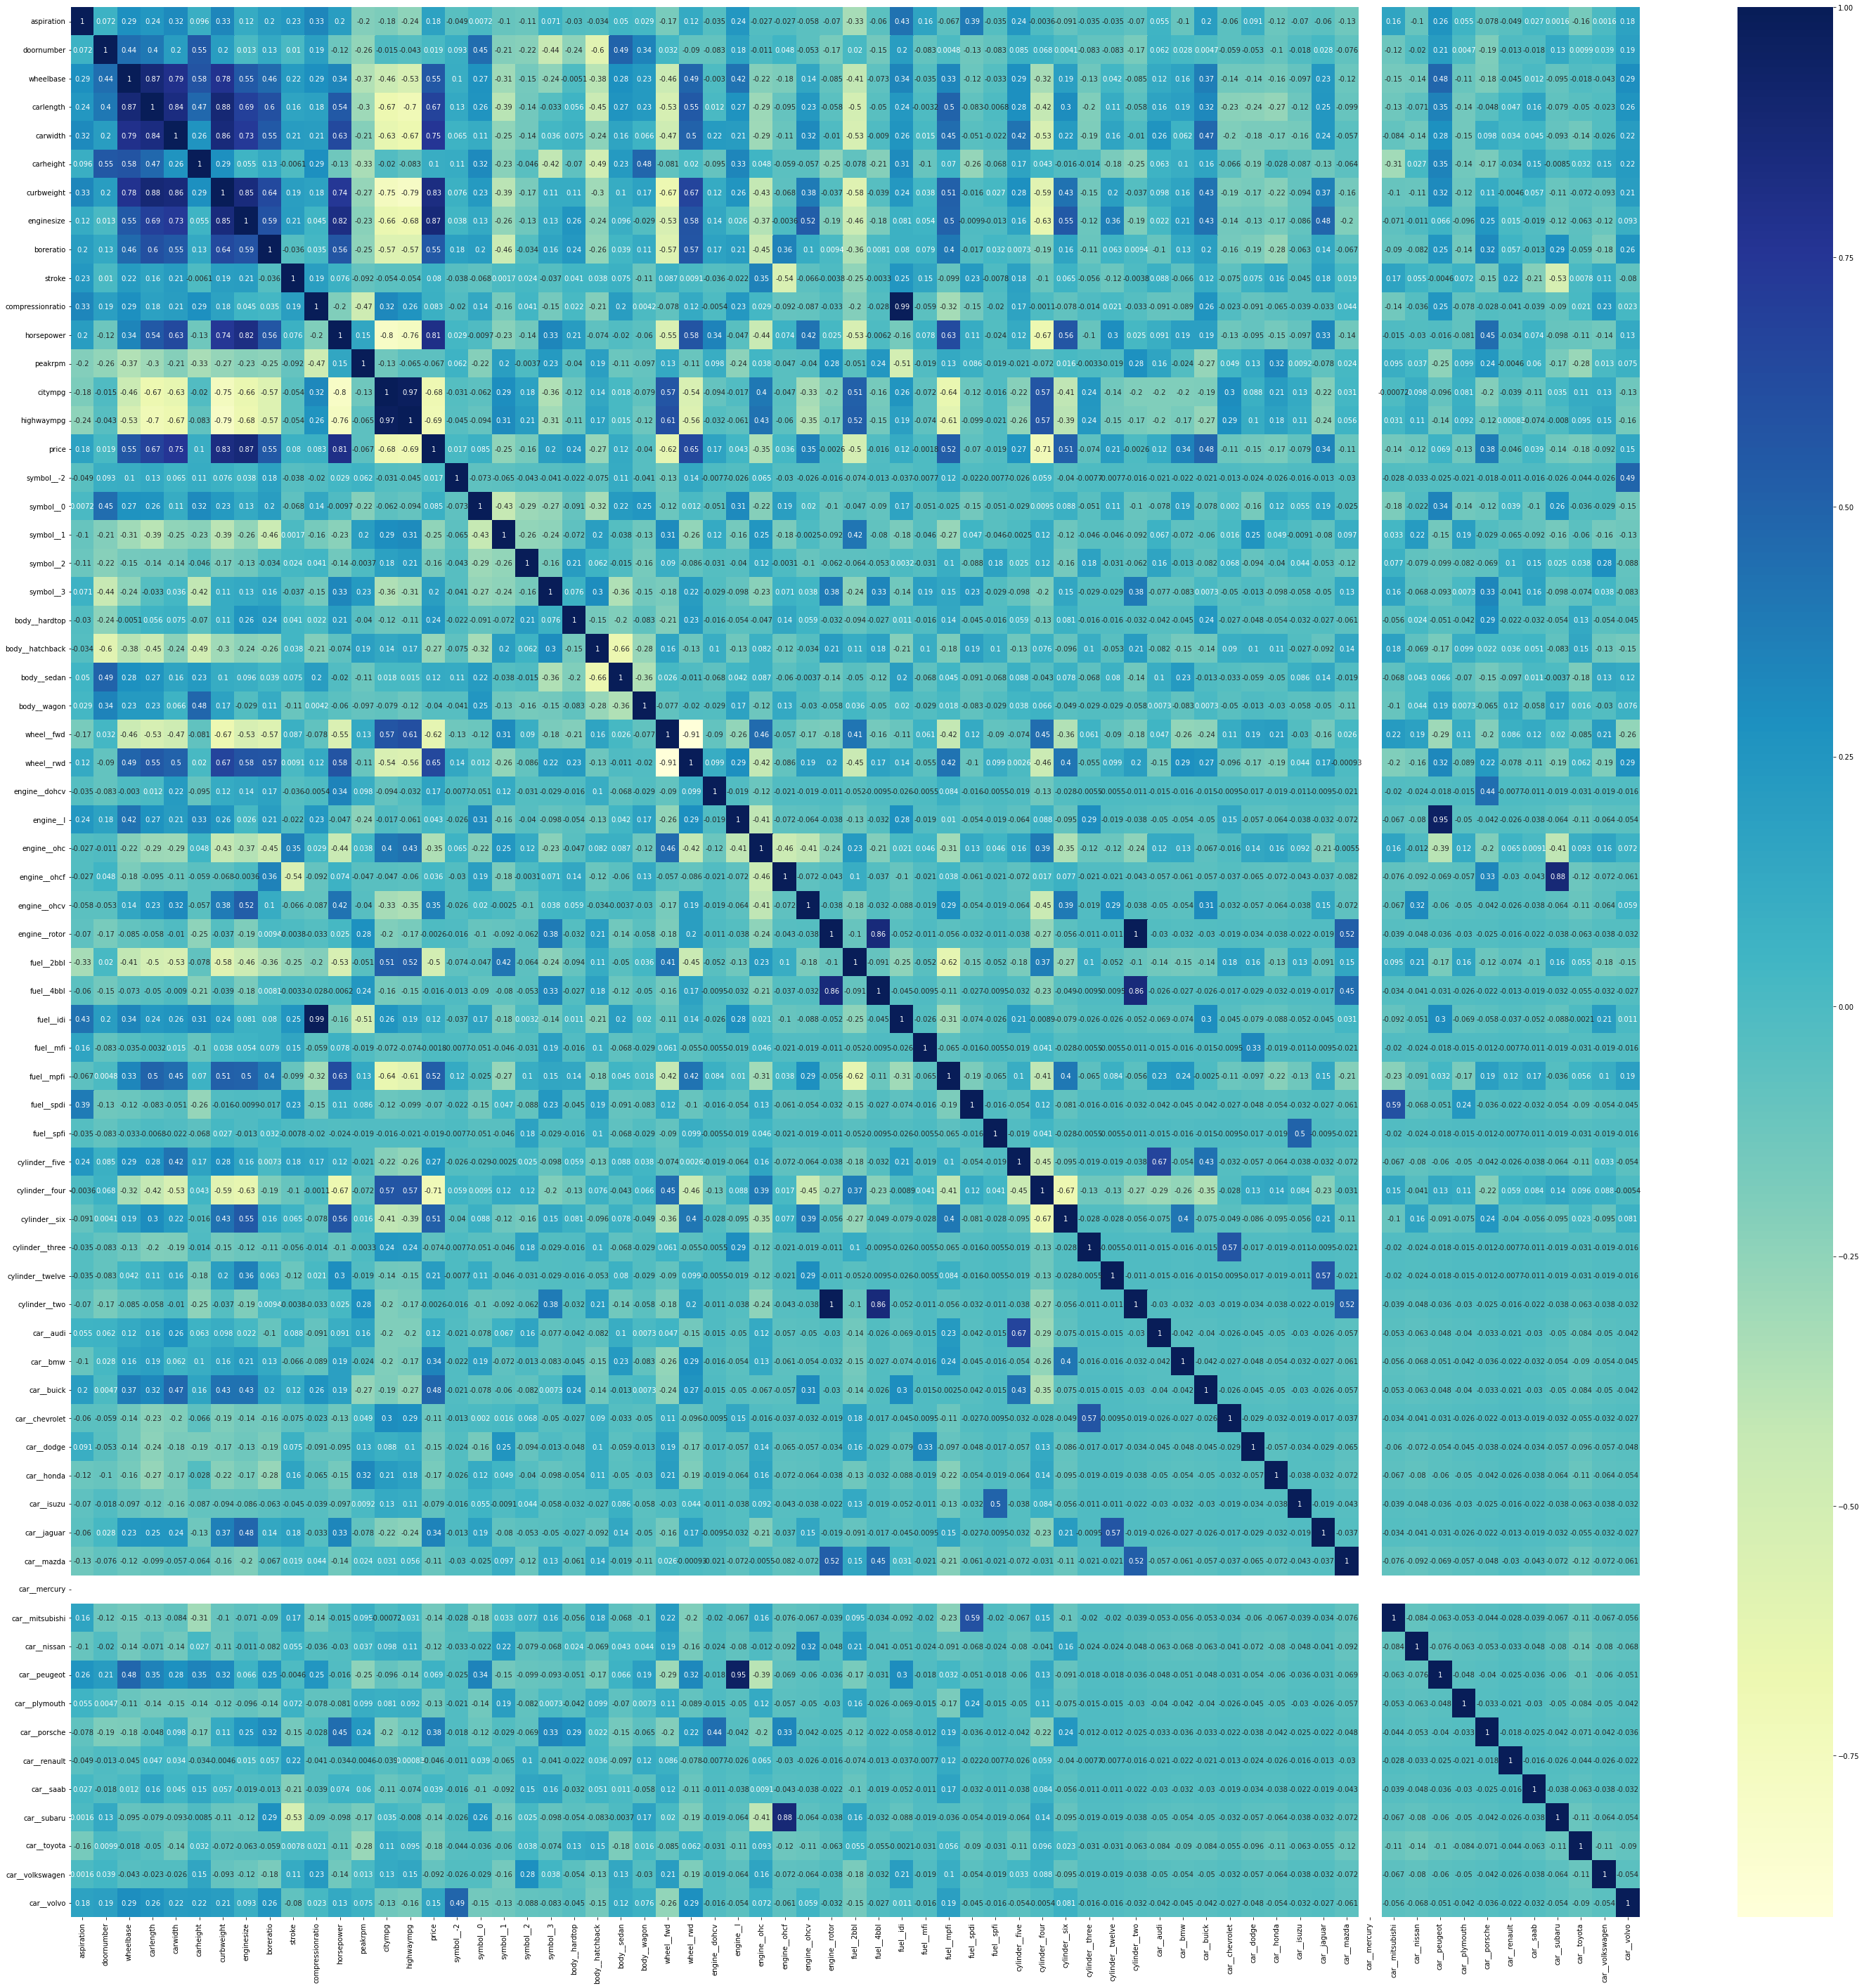

In [56]:
plt.figure(figsize = (50, 50))
sns_plo = sns.heatmap(cars_train.corr(), annot = True, cmap="YlGnBu")
plt.show()
sns_plo.figure.savefig("heatmap.png")
#plt.save('Heatmap.png')

Evidently car__mercury has no values, therefore we delete this column

In [57]:
cars_train = cars_train.drop('car__mercury',1)
cars_train.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


(184, 66)

----------------

<a id='model-1'></a>


## Model 1

This model process involves all the car_companies.

In [58]:
#Splitting the training data into X_train (independent) and y_train(dependent)
training = cars_train.copy()
y_train = training.pop('price')
X_train = training

In [59]:
#Creating 2 functions to create a model and print summary and another that returns the VIF

def create_model(dataset):
    # Build a fitted model
    train = sm.add_constant(dataset)
    lr = sm.OLS(y_train, train).fit()
    print(lr.summary())
    get_vif(dataset)
    return lr
    
def get_vif(dataset):
    vif = pd.DataFrame()
    vif['Features'] = dataset.columns
    vif['VIF'] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print('VIF values \n')
    print(vif)

In [60]:
model1_lr1 = create_model(X_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     62.17
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.15e-68
Time:                        15:11:53   Log-Likelihood:                 358.81
No. Observations:                 184   AIC:                            -589.6
Df Residuals:                     120   BIC:                            -383.9
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0674      0.122  

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF values 

           Features   VIF
42  cylinder__three   inf
27        engine__l   inf
56     car__peugeot   inf
44    cylinder__two   inf
31    engine__rotor   inf
..              ...   ...
20    body__hardtop  5.61
59     car__renault  3.68
35        fuel__mfi  2.94
38       fuel__spfi  2.92
15       symbol__-2  1.63

[65 rows x 2 columns]


**Analysis**

The model has a R-squared value of 0.97 and Adj.R-squared of 0.955 along with a low F-statistic value. This clearly indicates a poor and overfitted model.

To bring down the columns from 67 to a more reasonable number such as 15 or 20, we would be using RFE (automatic feature selection method) post which we would move on to manual selection.

---------------

### RFE

In [63]:
#Creating a linear regression model with sklearn
from sklearn.feature_selection import RFE

lm = LinearRegression()
lm.fit(X_train,y_train)
#Using RFE to bring down the variables from 66 to 15
rfe = RFE(lm,n_features_to_select = 15)
rfe = rfe.fit(X_train,y_train)
#Getting the list of selected columns
col_selected = X_train.columns[rfe.support_]
col_selected

Index(['carlength', 'carwidth', 'curbweight', 'enginesize', 'boreratio',
       'peakrpm', 'engine__ohcf', 'engine__ohcv', 'engine__rotor',
       'cylinder__three', 'car__bmw', 'car__buick', 'car__mitsubishi',
       'car__renault', 'car__subaru'],
      dtype='object')

As noticed before from the graphs, we can see that carlength, carwidth, curbweight and enginesize have been selected along with different engine types, cylinder types and car companies. Need to move to statsmodel to get better analysis and relevance of the selected variables

In [64]:
#Dataframe with RFE selected variables
X_train_rfe = X_train[col_selected]
#Creating Model 
model1_lr2 = create_model(X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     164.7
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           5.09e-92
Time:                        15:18:58   Log-Likelihood:                 288.74
No. Observations:                 184   AIC:                            -545.5
Df Residuals:                     168   BIC:                            -494.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1714      0.020     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

While the p-values, and r-squared values are good, it appears that curbweight is highly correlated to other variables, therefore it should be removed

In [65]:
X = X_train_rfe.drop('curbweight',1)
create_model(X)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     159.6
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.59e-89
Time:                        15:19:27   Log-Likelihood:                 279.60
No. Observations:                 184   AIC:                            -529.2
Df Residuals:                     169   BIC:                            -481.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1906      0.020     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

F-statistics has come has come down a bit, but not too significantly. However, it is interesting to notice that after removing the curbweight, the p-value for carlength has increased up to 0.8. This suggestes that they both are most likely highly correlated.

In [66]:
X_3 = X.drop('carlength',1)
model1_lr3 = create_model(X_3)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     172.8
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.22e-90
Time:                        15:19:43   Log-Likelihood:                 279.56
No. Observations:                 184   AIC:                            -531.1
Df Residuals:                     170   BIC:                            -486.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1895      0.019     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

The rise in the F-statistic clearly shows that it was a good decision to remove car length. Our model is decently good, however we still see a high VIF value for boreratio, carwidth and engine size. 

Boreratio can be removed first considering the fact that it has a VIF value and a p-value greater than 0.05

In [67]:
X = X_3.drop('boreratio',1)
create_model(X)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     185.5
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           2.84e-91
Time:                        15:19:54   Log-Likelihood:                 278.28
No. Observations:                 184   AIC:                            -530.6
Df Residuals:                     171   BIC:                            -488.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.2037      0.017    -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

R-squared values, F-statistic and other metrics indicate a good model. Even the p-values are low, however the model still seems to be affected by multi-collinearity. Car width has a VIF as high as 16.78. This column should be dropped.

In [68]:
X = X.drop('carwidth',1)
create_model(X)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     127.3
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.49e-76
Time:                        15:20:04   Log-Likelihood:                 238.96
No. Observations:                 184   AIC:                            -453.9
Df Residuals:                     172   BIC:                            -415.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1228      0.018     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

Dropping of car width has caused an increase in the p-value of cylinder_three while also reducing the f-statistic from before. Even the AIC has increased. 

In [69]:
X = X.drop('cylinder__three',1)
create_model(X)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     139.7
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           2.25e-77
Time:                        15:20:13   Log-Likelihood:                 238.30
No. Observations:                 184   AIC:                            -454.6
Df Residuals:                     173   BIC:                            -419.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1201      0.018     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

At this point, the model seems relatively stable, but it could possibly be improved. 

2 variations that could be tried are:
1. Remove engine_ohcf: if has a VIF value slightly more than 5
2. Remove car_renault: it's p-value is kind of close to 0.05

In [70]:
X_ohcf = X.drop('engine__ohcf',1)
model1_lr4 = create_model(X_ohcf)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     131.9
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           6.79e-73
Time:                        15:20:21   Log-Likelihood:                 224.62
No. Observations:                 184   AIC:                            -429.2
Df Residuals:                     174   BIC:                            -397.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1534      0.018     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [71]:
X_renault = X.drop('car__renault',1)
create_model(X_renault)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     152.0
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.38e-77
Time:                        15:20:28   Log-Likelihood:                 236.10
No. Observations:                 184   AIC:                            -452.2
Df Residuals:                     174   BIC:                            -420.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1203      0.018     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

Evidently, the model without car_renault is doing better than the one without ohcf. It is also proven that the previous model could be improved. We can further improve this one as well by first let's try removing car_subaru. We have established that ohcf may be important to some extent so here the next feature with a VIF close to 5 can be removed.

In [72]:
X_renault = X_renault.drop('car__subaru',1)
create_model(X_renault)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     149.2
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           5.47e-74
Time:                        15:20:37   Log-Likelihood:                 224.60
No. Observations:                 184   AIC:                            -431.2
Df Residuals:                     175   BIC:                            -402.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1584      0.018     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Well, this is still a good model, but giving a shot at increasing the f-statistic, we can try to remove the engine_ohcf. This may improve the model to some extent.

In [73]:
X_renault = X_renault.drop('engine__ohcf',1)
model1_lr5 = create_model(X_renault)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     166.8
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           3.40e-74
Time:                        15:20:50   Log-Likelihood:                 222.36
No. Observations:                 184   AIC:                            -428.7
Df Residuals:                     176   BIC:                            -403.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1547      0.018     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

Removing OHCF did not impact our P-values that much, however there was a hike in the F-statistic. Therefore at this point, considering the following factors, we can conclude that we have a good model:
1. R-Squared and Adjusted R-Squared at 0.86. Clearly it is not an overfit and the model also explains a large chunk of the data
2. AIC is low
3. F-Statistic: relatively high
4. No P-values greater than 0.05. Most are at 0.0
5. Decently high T-values (especially for engine size)
6. All VIF values less than 5

-------------

<a id='model-2'></a>


## Model 2

From the previous model it is evident that the car companies are dominating the features, therefore these could be removed to identify other possible features.

In [74]:
#Dropping the columns starting with car__
training_2 = cars_train.copy()
y_train = training_2.pop('price')
cols = training_2.columns[~training_2.columns.str.startswith('car__')]
X_train_2 = training_2.loc[:,cols]
X_train_2.shape

(184, 45)

In [75]:
model2_lr1 = create_model(X_train_2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     52.23
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           2.05e-67
Time:                        15:21:05   Log-Likelihood:                 298.86
No. Observations:                 184   AIC:                            -507.7
Df Residuals:                     139   BIC:                            -363.1
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0212      0.110  

**Analysis**

The model created has a high R and Adjusted R value, however it has way too many variables and a relatively low F-statistic. Therefore, first we can begin with RFE and then move on to manual feature selection

-----------

### RFE

In [77]:
#Creating a linear regression model with sklearn
lm = LinearRegression()
lm.fit(X_train_2,y_train)
#Using RFE to bring down the variables from 66 to 15
rfe = RFE(lm,n_features_to_select=15)
rfe = rfe.fit(X_train_2,y_train)
#Getting the list of selected columns
col_selected = X_train_2.columns[rfe.support_]
col_selected

Index(['carlength', 'carwidth', 'curbweight', 'enginesize', 'stroke',
       'horsepower', 'peakrpm', 'symbol__-2', 'engine__dohcv', 'engine__ohcv',
       'fuel__idi', 'cylinder__five', 'cylinder__four', 'cylinder__six',
       'cylinder__twelve'],
      dtype='object')

In [78]:
X_train2_rfe = X_train_2[col_selected]
model2_lr2 = create_model(X_train2_rfe)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     105.0
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           5.43e-77
Time:                        15:21:34   Log-Likelihood:                 250.59
No. Observations:                 184   AIC:                            -469.2
Df Residuals:                     168   BIC:                            -417.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0796      0.040  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

The new model with the RFE selected features has brought down the columns from 45 to 15. Also it appears that although the R-square and the Adj. R-square value saw less difference, the F-statistic shows a significant change. Although this is a relatively better model, we can see that there is high multi-collinearity and some variables that are not ocntributing much (high p-value)
One of them is Horsepower, which can be removed

In [79]:
X = X_train2_rfe.drop('horsepower',1)
create_model(X)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     112.0
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.11e-77
Time:                        15:21:46   Log-Likelihood:                 249.71
No. Observations:                 184   AIC:                            -469.4
Df Residuals:                     169   BIC:                            -421.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0745      0.040  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

There are still p-values greater than 0.05. The highest p-value at this point is 0.160 which is for symbol_-2. This can be removed

In [80]:
X = X.drop('symbol__-2',1)
create_model(X)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     119.7
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           2.66e-78
Time:                        15:21:59   Log-Likelihood:                 248.63
No. Observations:                 184   AIC:                            -469.3
Df Residuals:                     170   BIC:                            -424.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0804      0.040  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

There was less to no change in the R-squared values suggesting that symbol wasn't an important variable. However there is still curbweight which has a high p-value and VIF values. Therefore this can be removed.

In [81]:
X = X.drop('curbweight',1)
create_model(X)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     128.6
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           7.02e-79
Time:                        15:22:08   Log-Likelihood:                 247.41
No. Observations:                 184   AIC:                            -468.8
Df Residuals:                     171   BIC:                            -427.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0805      0.040  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

Removing of curb weight shows an increase in the p-value of car length.

In [82]:
X = X.drop('carlength',1)
create_model(X)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     140.0
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.05e-79
Time:                        15:22:15   Log-Likelihood:                 246.77
No. Observations:                 184   AIC:                            -469.5
Df Residuals:                     172   BIC:                            -431.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0762      0.040  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

Carwidth seems to be highly correlated to engine size and other features therefore this can be dropped.

In [83]:
X = X.drop('carwidth',1)
create_model(X)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     141.2
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           9.95e-78
Time:                        15:22:22   Log-Likelihood:                 239.17
No. Observations:                 184   AIC:                            -456.3
Df Residuals:                     173   BIC:                            -421.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1309      0.039  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

While the metrics and the p-values suggest a good model. The VIF gives indication of multicolliniearity for stroke.

In [84]:
X = X.drop('stroke',1)
create_model(X)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     119.3
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.28e-69
Time:                        15:22:30   Log-Likelihood:                 216.59
No. Observations:                 184   AIC:                            -413.2
Df Residuals:                     174   BIC:                            -381.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0312      0.041  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

While cylinder 4 has a high VIF, engine_dohcv has a high p-value. Focusing first on p-value we drop the engine_dohcv

In [85]:
X = X.drop('engine__dohcv',1)
create_model(X)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     133.2
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           2.90e-70
Time:                        15:22:37   Log-Likelihood:                 215.54
No. Observations:                 184   AIC:                            -413.1
Df Residuals:                     175   BIC:                            -384.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0248      0.041  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

All our p-values are in a good range but we still have a little multi collinearity. The 2 features greater than 5 are engine size and cylinder 4. They are both around the same range. However I choose to drop cylinder_four over enginesize because 
   1. previous models and graphs have shown its significance. 
   2. COnsidering business and real life aspect, engine size holds more significance
   3. Engine size has a greater T-value than cylinder four

In [86]:
X = X.drop('cylinder__four',1)
create_model(X)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     117.2
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           7.90e-63
Time:                        15:22:44   Log-Likelihood:                 194.86
No. Observations:                 184   AIC:                            -373.7
Df Residuals:                     176   BIC:                            -348.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.2022      0.025  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

Dropping cylinder 4 has increased the p-value for cylinder 6. Therefore this can be dropped

In [87]:
X_2_3 = X.drop('cylinder__six',1)
model2_lr3 = create_model(X_2_3)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     136.9
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           9.00e-64
Time:                        15:22:51   Log-Likelihood:                 194.51
No. Observations:                 184   AIC:                            -375.0
Df Residuals:                     177   BIC:                            -352.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.2086      0.023  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**Analysis**

At this point we can be satisfied with out model since it has good enough R-squared and Adj.R-Squared values . F-statistic is also moderately high and most importantly all the p-values are less than 0.05 with the VIF values being less than 5

-------------

<a id='residual-analysis'></a>


## Residual Analysis

Residual analysis of all the model could be checked along with the predicted graphs to get a better understanding of all the factors

In [88]:
def residual_analysis(model,dataset):
    #Predicting the values
    X_train_lm = sm.add_constant(X_renault)
    lr2 = sm.OLS(y_train, X_train_lm).fit()
    y_train_price = lr2.predict(X_train_lm)
    #Plotting error terms
    error = y_train - y_train_price 
    return error

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `d

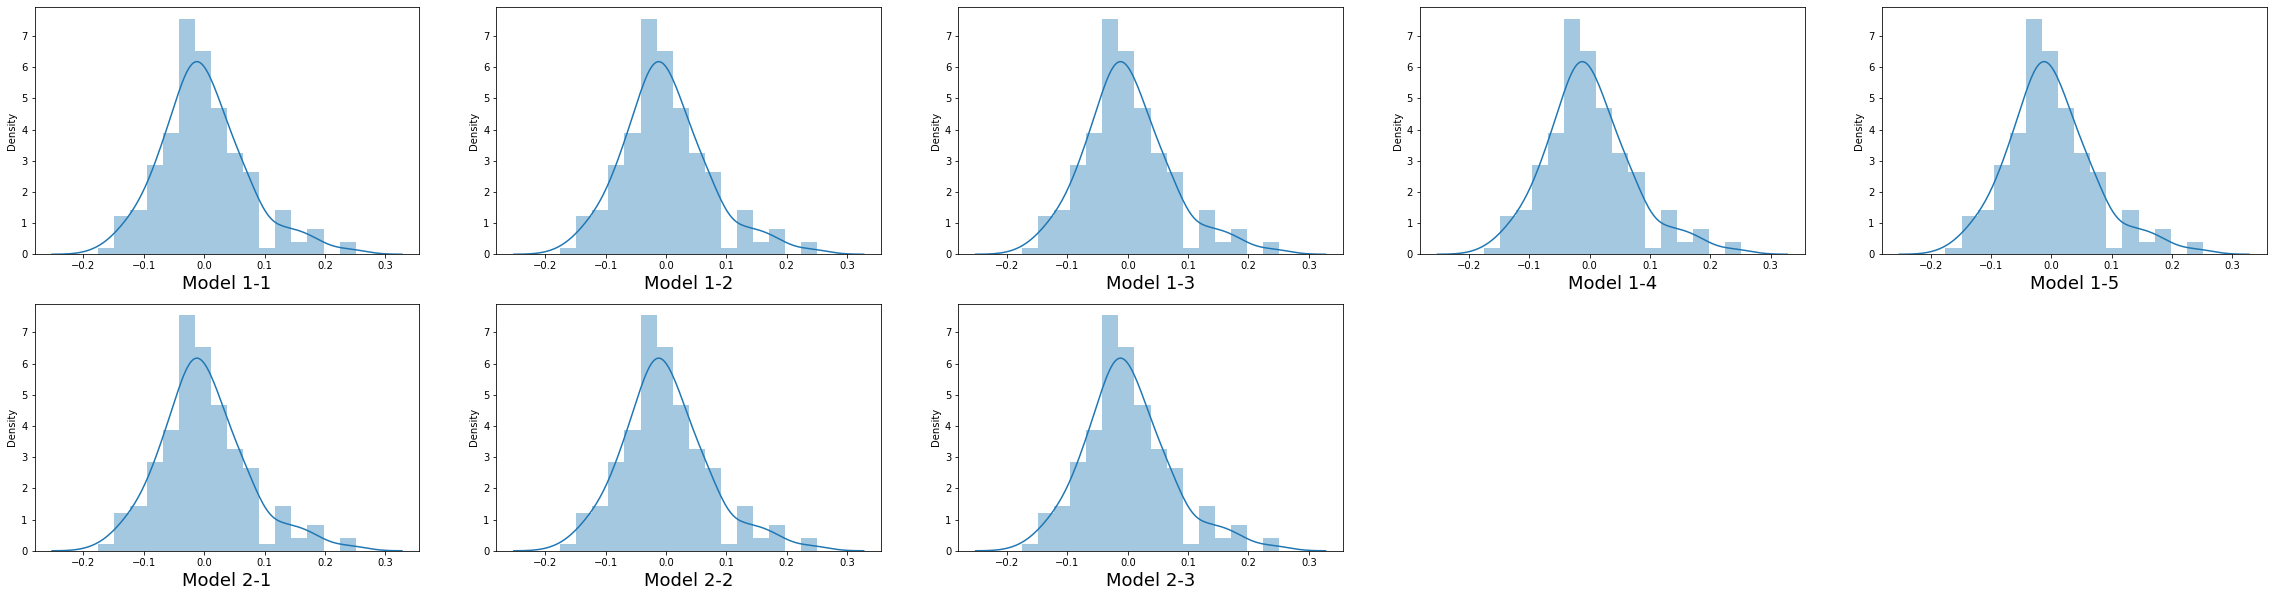

In [90]:
plt.figure(figsize=(40, 10))

#Models from Model 1
plt.subplot(2,5,1)
sns.distplot((residual_analysis(model1_lr1,X_train)))
plt.xlabel('Model 1-1', fontsize = 18)
plt.subplot(2,5,2)
sns.distplot((residual_analysis(model1_lr2,X_train_rfe)))
plt.xlabel('Model 1-2', fontsize = 18)
plt.subplot(2,5,3)
sns.distplot((residual_analysis(model1_lr3,X_3)))
plt.xlabel('Model 1-3', fontsize = 18)
plt.subplot(2,5,4)
sns.distplot((residual_analysis(model1_lr4,X_ohcf)))
plt.xlabel('Model 1-4', fontsize = 18)
plt.subplot(2,5,5)
sns.distplot((residual_analysis(model1_lr5,X_renault)))
plt.xlabel('Model 1-5', fontsize = 18)

#Models from Model 2
plt.subplot(2,5,6)
sns.distplot((residual_analysis(model2_lr1,X_train_2)))
plt.xlabel('Model 2-1', fontsize = 18)
plt.subplot(2,5,7)
sns.distplot((residual_analysis(model2_lr2,X_train2_rfe)))
plt.xlabel('Model 2-2', fontsize = 18)
plt.subplot(2,5,8)
sns.distplot((residual_analysis(model2_lr3,X_2_3)))
plt.xlabel('Model 2-3', fontsize = 18)
plt.savefig('model_plots.png')

**Analysis**

The graphs above support our assumption that the error terms are normally distributed. This is more or less seen for all the models.

-----------------

<a id='prediction'></a>

## Predictions

Now, we can move on to predicting the y-values using the models we've created so far. These could be plotted in graphs and used to find the r2 score and mean squared error. These could be compared later, to identify the best models

In [91]:
#Feature Scaling
cars_test[num_vars] = scaler.transform(cars_test[num_vars])

In [92]:
#Splitting into X_test and Y_test
y_test = cars_test.pop('price')
X_test = cars_test

In [93]:
#Giving y_pred values based on the model
def predictor(model,dataset):
    predictor = X_test.loc[:,dataset.columns]
    predictor = sm.add_constant(predictor)
    y_pred = model.predict(predictor)
    return y_pred

#Appends metrics dataframe with model name, mean squared error and r2 score
def get_metrics(df,model,y_pred):
    mse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)
    metrics_value = {'Model':model,
                    'Mean_squared':mse,
                    'R2_Score':r2
                   }
    return metrics_value

In [94]:
metrics = pd.DataFrame(columns=['Model','Mean_squared','R2_Score'])

In [95]:
#Model 1 stats
y_pred_1 = predictor(model1_lr1,X_train)
metric1 = get_metrics(metrics,'Model 1-1',y_pred_1)
metrics.loc[1] = metric1

y_pred_2 = predictor(model1_lr2,X_train_rfe)
metric2 = get_metrics(metrics,'Model 1-2',y_pred_2)
metrics.loc[2] = metric2

y_pred_3 = predictor(model1_lr3,X_3)
metric3 = get_metrics(metrics,'Model 1-3',y_pred_3)
metrics.loc[3] = metric3

y_pred_4 = predictor(model1_lr4,X_ohcf)
metric4 = get_metrics(metrics,'Model 1-4',y_pred_4)
metrics.loc[4] = metric4

y_pred_5 = predictor(model1_lr5,X_renault)
metric5 = get_metrics(metrics,'Model 1-5',y_pred_5)
metrics.loc[5] = metric5

#Model 2 stats
y_pred_6 = predictor(model2_lr1,X_train_2)
metric6 = get_metrics(metrics,'Model 2-1',y_pred_6)
metrics.loc[6] = metric6

y_pred_7 = predictor(model2_lr2,X_train2_rfe)
metric7 = get_metrics(metrics,'Model 2-2',y_pred_7)
metrics.loc[7] = metric7

y_pred_8 = predictor(model2_lr3,X_2_3)
metric8 = get_metrics(metrics,'Model 2-3',y_pred_8)
metrics.loc[8] = metric8

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

In [96]:
metrics.sort_values(by=['Mean_squared','R2_Score'],ascending=False)

,Model,Mean_squared,R2_Score
6,Model 2-1,0.068533,0.853698
8,Model 2-3,0.064931,0.868672
1,Model 1-1,0.064712,0.869556
5,Model 1-5,0.064069,0.872135
4,Model 1-4,0.063621,0.873918
7,Model 2-2,0.060055,0.887658
3,Model 1-3,0.059526,0.889626
2,Model 1-2,0.054606,0.907119


These metrics show that Model 1-2 seems to have the less Mean Squared Error and the highest R2 Score. Clearly suggests that it had relevant features, however it may have been too many.

Putting this model aside we can see that other models seem to have a good enough score as well.

Also, it is interesting to notice that our training and test set have returned R2 squared scores in around the same range.

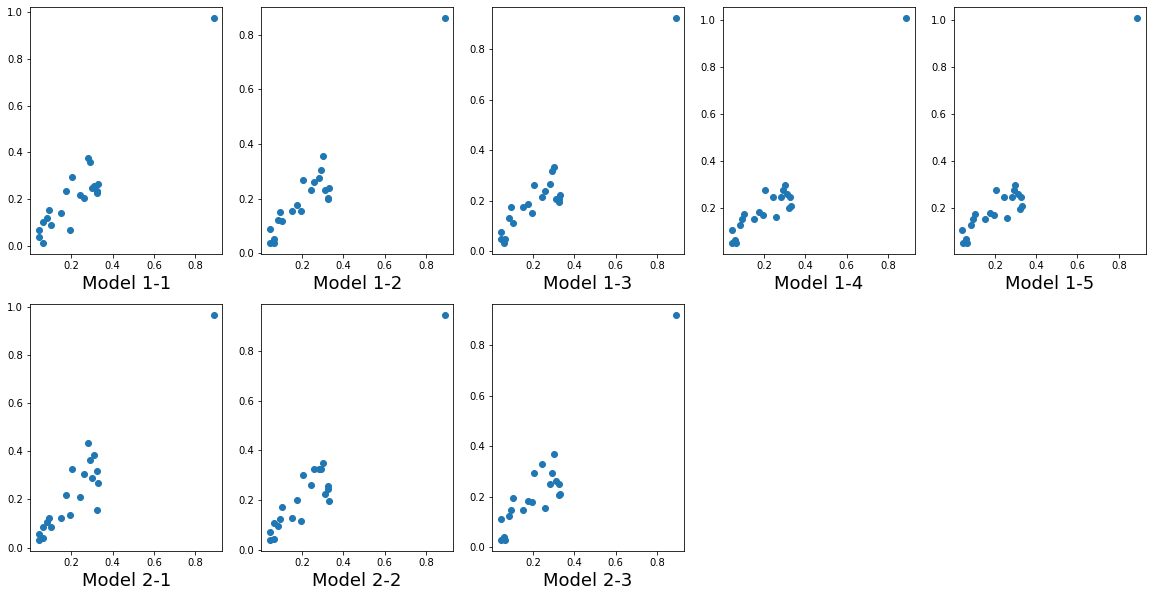

In [97]:
# Plotting y_test and y_pred to understand the spread of different models

plt.figure(figsize=(20, 10))

#Model 1 plots
plt.subplot(2,5,1)
plt.scatter(y_test, y_pred_1)
plt.xlabel('Model 1-1', fontsize = 18)
plt.subplot(2,5,2)
plt.scatter(y_test, y_pred_2)
plt.xlabel('Model 1-2', fontsize = 18)
plt.subplot(2,5,3)
plt.scatter(y_test, y_pred_3)
plt.xlabel('Model 1-3', fontsize = 18)
plt.subplot(2,5,4)
plt.scatter(y_test, y_pred_4)
plt.xlabel('Model 1-4', fontsize = 18)
plt.subplot(2,5,5)
plt.scatter(y_test, y_pred_5)
plt.xlabel('Model 1-5', fontsize = 18)

#Model 2 plots
plt.subplot(2,5,6)
plt.scatter(y_test, y_pred_6)
plt.xlabel('Model 2-1', fontsize = 18)
plt.subplot(2,5,7)
plt.scatter(y_test, y_pred_7)
plt.xlabel('Model 2-2', fontsize = 18)
plt.subplot(2,5,8)
plt.scatter(y_test, y_pred_8)
plt.xlabel('Model 2-3', fontsize = 18)
plt.savefig('model_spread.png')

**Analysis**

Through different analysis of the error plots, and the different metrics like AIC, F-statistic, R-squared and Adjusted R-Square it is clear that Model 1 is better in analysis and gives back most accurate model as compared to others. 

From Model 1, I would choose the 5th one (Model 1-5) and in Model 3, I would choose the 3rd one (Model 2-3) because both of these models have limited number of features of about 6 or 7. Also while some of their metrics may be slightly less than other models, it is a best fit because those are the models where all the p-values are below 0.05 and VIF is less than 5. 

-------------------

<a id='model-evaluation'></a>

## Model Evaluation

### Model 1: with car company names, we find that the following are important features:

To decide the features, Model 1-5 has been chosen since that is the one with the fewest variables, high R and adjusted R values, high F-statistic and also it has no p-values>0.05 or VIF>5

Following are the Features and their relevance to price:
1. **Engine Size**: 1 normalised unit increase: Increase in mean price by 1.15
2. **Peak RPM**: 1 normalised unit increase: Increase in mean price by 0.17
3. **Engine Type:OHCV**: 1 normalised unit increase: Decrease in mean price by 0.14
4. **Car Company: Buick**: 1 normalised unit increase: Increase in mean price by 0.21
5. **Car Company: BMW**: 1 normalised unit increase: Increase in mean price by 0.15
6. **Cylinder Number 2**: 1 normalised unit increase: Increase in mean price by 0.175
7. **Car Company: Mitsubhishi**: 1 normalised unit increase: Decrease in mean price by 0.07

**Equation for Best Fit Line:** 

> Price = 1.15 X *enginesize* + 0.17 X *peakrpm* - 0.14 X *engine_ohcv* + 0.175 X *cylinder_2* + 0.15 X *bmw* + 0.21 X *buick*  - 0.07 X *mitsubishi* - 0.15

Clearly Engine size has the most impact on price as compared to others and also it appears that car companies also make a difference. A Mitsubishi car is less expensive than a BMW or Buick

--------------------

### Model 2: without car company names

The metrics values for the model created without the company names may not be as great as from model 1, however we get a better insight on which other features could be relevant to Gelly Autos.

The features that have been identified in Model 2-3 and their relevance to the price are:
1. **Engine Size** : 1 normalised unit increase: Increase in mean price by 1.28
2. **Peak RPM** : 1 normalised unit increase: Increase in mean price by 0.22
3. **Engine Type:OHCV** : 1 normalised unit increase: Decrease in mean price by 0.09
4. **Fuel System: IDI** : 1 normalised unit increase: Increase in mean price by 0.075
5. **Cylinder Number: 5** : 1 normalised unit increase: Increase in mean price by 0.066
6. **Cylinder Number:12** : 1 normalised unit increase: Decrease in mean price by 0.29

**Equation for Best Fit Line:** 

> Price = 1.28 X *enginesize* + 0.22 X *peakrpm* - 0.09 X *engine_ohcv* + 0.075 X *fuel_idi* + 0.066 X *cylinder_5* - 0.29 X *cylinder_12* - 0.21

Clearly Engine size is an important features. While IDI fule system and a higher Peak RPM is also another way to increase the price. Also it is noticed that, Engine Type: OHCV should be avoided, since it is more likely to lead to a decrease in price. Another thing to notice is the number of cylinders, 5 is the optimum number. Increasing it to 12 leads to a decline.

---------------------

### Other Features:
While other models may not be too accurate it is interesting to see that a lot of them could be considered important. This can be figured on the basis of their graphs during EDA analysis and by looking at how much the metrics' dropped after we removed the features. These may all be correlated variables, but it would be a good idea to have them in mind as well while designing the cars.

1. Curb weight, car length, horse power, car width: highly correalted with each other but can see some correlation in the graphs. They were also the selected features from RFE
2. Engine type: OHCF could be a better option than OHCV. From the models it could be seen that OHCF had a positive coefficient. Clearly suggesting that it could help in increase the price contrary to what is the case with OHCV.

---------------

<a id='suggestion'></a>


## Suggestion

Final solution for Scania AB Business plan:
One of the factors affecting the price is company name. Brand holds a certain value that influences the price. While this is out of Scania AB's control, they have other features that they can control. 
1. **Engine Size**: this is one of the most important feature in determining the price. Greater, the better
2. **Engine Type**: avoid OHCV, one better option could be OHCF.
3. **Fuel System**: IDI is a good suggestion. It does not affect the price much though
4. **No.of Cylinders**: avoid 12, choose either 2 or 5. Although looking at the 2 models it seems that 2 has more impact on the price.
5. **Peak RPM**: both the models show that it has some significant on the price of a car
6. **Car length**: along with this, during the analysis it was evident that **curb weight, horsepower & car width** are also important features. Although they were highly correlated to the other features, it is important to note the significance of these features as well


**Concluding Statement**: while our model has given a good insight on the factors that affect the price of cars in the USA, we can always improvise on the model by trying out different regression models such as Linear Regression. Additionally it is clear that the existing feature were more than useful, it could also be enhanced further by adding more derived variables.

-----------------

<a id='glossary'></a>

## Glossary of Terms:

It would be a good idea to know what the different features that have been selected mean, therefore below are a bunch og simple explanation for this.

1. Engine Size: it is measured by displacement and is generally calculated in cubic centimeters (cc). In simple words it is the volume of all the cylinders

2. Peak RPM: RPM stands for revolutions per minute. It basically is a measure of how fast a machine operates at a given time. Peak RPM would be the fasted it operates

3. Engine Type: these are the different design of engines

4. Fuel System: this is mainly made of the fuel tank, fuel pump, filters,etc. 

5. Cylinder: this clearly to some extent affects the engine size. This is where the fuel is burned and converted to power. It is a part of the engine. 